In [48]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import scipy.stats as st

# Load Data

In [49]:
df = pd.read_excel("Datasæt_Gallstone.xlsx")

X = df.drop(columns=["Gallstone Status"])
y = df["Gallstone Status"]

print("Dataset shape:", X.shape)
print("Binary classes:", y.unique())

Dataset shape: (319, 7)
Binary classes: [0 1]


# Helper Functions

In [50]:
def jeffrey_interval(y_true, y_pred, alpha=0.05):
    """Compute Jeffreys confidence interval for accuracy."""
    n = len(y_true)
    m = np.sum(y_true == y_pred)
    a = m + 0.5
    b = n - m + 0.5
    theta_hat = a / (a + b)
    CI = st.beta.interval(1 - alpha, a=a, b=b)
    return theta_hat, CI


def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    """
    Perform McNemar's test to compare two classifiers (DTU format).
    """
    nn = np.zeros((2, 2))
    cA = yhatA == y_true
    cB = yhatB == y_true

    nn[0, 0] = sum(cA & cB)
    nn[0, 1] = sum(cA & ~cB)
    nn[1, 0] = sum(~cA & cB)
    nn[1, 1] = sum(~cA & ~cB)

    n = len(y_true)
    n12 = nn[0, 1]
    n21 = nn[1, 0]

    E_theta = (n12 - n21) / n
    Q = (
        n**2 * (n + 1) * (E_theta + 1) * (1 - E_theta)
        / (n * (n12 + n21) - (n12 - n21)**2)
    )

    f = (E_theta + 1) / 2 * (Q - 1)
    g = (1 - E_theta) / 2 * (Q - 1)
    CI = tuple(bound * 2 - 1 for bound in st.beta.interval(1 - alpha, a=f, b=g))
    p = 2 * st.binom.cdf(min([n12, n21]), n=n12 + n21, p=0.5)

    print(f"\nResult of McNemar’s test (α = {alpha})")
    print("Contingency table:\n", nn)
    if n12 + n21 <= 10:
        print(f"Warning: low disagreement count (n12+n21 = {n12+n21})")

    print(f"Approx. {100*(1-alpha):.1f}% CI of θ: [{CI[0]:.4f}, {CI[1]:.4f}]")
    print(f"p-value (exact binomial): {p:.4f}\n")

    return E_theta, CI, p, n12, n21

# Two-Level Cross-Validation

In [51]:
K_outer = 10
K_inner = 5
outer_cv = StratifiedKFold(n_splits=K_outer, shuffle=True, random_state=42)

Etest_base, Etest_log, Etest_knn = [], [], []
lambda_list, k_list = [], []

y_true_all, y_pred_log_all, y_pred_knn_all = [], [], []

for outer_fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y)), total=K_outer):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- Standardize (fit only on training data) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ============================================================
    # Baseline Model
    # ============================================================
    majority_class = y_train.mode()[0]
    y_pred_base = np.repeat(majority_class, len(y_test))
    Etest_base.append(np.mean(y_pred_base != y_test))

    # ============================================================
    # Logistic Regression
    # ============================================================
    inner_cv = StratifiedKFold(n_splits=K_inner, shuffle=True, random_state=1)
    lambdas = [0.001, 0.01, 0.1, 1, 10]
    best_lambda, best_error = None, np.inf

    for lam in lambdas:
        inner_errors = []
        for train_i, val_i in inner_cv.split(X_train_scaled, y_train):
            X_tr, X_val = X_train_scaled[train_i], X_train_scaled[val_i]
            y_tr, y_val = y_train.iloc[train_i], y_train.iloc[val_i]

            logreg = LogisticRegression(C=1/lam, max_iter=1000)
            logreg.fit(X_tr, y_tr)
            y_val_pred = logreg.predict(X_val)
            inner_errors.append(np.mean(y_val_pred != y_val))
        mean_error = np.mean(inner_errors)
        if mean_error < best_error:
            best_error, best_lambda = mean_error, lam

    log_final = LogisticRegression(C=1/best_lambda, max_iter=1000)
    log_final.fit(X_train_scaled, y_train)
    y_pred_log = log_final.predict(X_test_scaled)
    Etest_log.append(np.mean(y_pred_log != y_test))
    lambda_list.append(best_lambda)

    # ============================================================
    # KNN (Method 2)
    # ============================================================
    ks = [1, 3, 5, 7, 9]
    best_k, best_error = None, np.inf

    for k in ks:
        inner_errors = []
        for train_i, val_i in inner_cv.split(X_train_scaled, y_train):
            X_tr, X_val = X_train_scaled[train_i], X_train_scaled[val_i]
            y_tr, y_val = y_train.iloc[train_i], y_train.iloc[val_i]

            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_tr, y_tr)
            y_val_pred = knn.predict(X_val)
            inner_errors.append(np.mean(y_val_pred != y_val))
        mean_error = np.mean(inner_errors)
        if mean_error < best_error:
            best_error, best_k = mean_error, k

    knn_final = KNeighborsClassifier(n_neighbors=best_k)
    knn_final.fit(X_train_scaled, y_train)
    y_pred_knn = knn_final.predict(X_test_scaled)
    Etest_knn.append(np.mean(y_pred_knn != y_test))
    k_list.append(best_k)

    # Store for McNemar test
    y_true_all.extend(y_test)
    y_pred_log_all.extend(y_pred_log)
    y_pred_knn_all.extend(y_pred_knn)


100%|██████████| 10/10 [00:00<00:00, 14.33it/s]


# Results Table

In [52]:
table = pd.DataFrame({
    "Fold": np.arange(1, K_outer + 1),
    "k* (KNN)": k_list,
    "E_test (KNN)": np.round(Etest_knn, 3),
    "λ* (LogReg)": lambda_list,
    "E_test (LogReg)": np.round(Etest_log, 3),
    "E_test (Baseline)": np.round(Etest_base, 3)
})
print("\n=== Two-Level Cross-Validation Table ===")
print(table.to_string(index=False))

print("\n=== Mean Outer Test Errors ===")
print(f"Baseline:          {np.mean(Etest_base):.3f}")
print(f"Logistic regression: {np.mean(Etest_log):.3f}")
print(f"KNN:                 {np.mean(Etest_knn):.3f}")


=== Two-Level Cross-Validation Table ===
 Fold  k* (KNN)  E_test (KNN)  λ* (LogReg)  E_test (LogReg)  E_test (Baseline)
    1         9         0.438        0.001            0.219              0.469
    2         9         0.312        1.000            0.156              0.500
    3         9         0.344        1.000            0.312              0.500
    4         9         0.250        0.001            0.188              0.500
    5         9         0.281        1.000            0.312              0.500
    6         9         0.312        0.100            0.156              0.500
    7         9         0.219        1.000            0.281              0.500
    8         5         0.438        1.000            0.344              0.500
    9         5         0.281        0.001            0.188              0.500
   10         3         0.290        0.001            0.226              0.484

=== Mean Outer Test Errors ===
Baseline:          0.495
Logistic regression: 0.238
KNN: 

# Confidence Intervals and McNemar’s Test

In [53]:
alpha = 0.05

pairs = [
    ("Logistic vs KNN", y_pred_log_all, y_pred_knn_all),
    ("Logistic vs Baseline", y_pred_log_all, np.repeat(y.mode()[0], len(y_true_all))),
    ("KNN vs Baseline", y_pred_knn_all, np.repeat(y.mode()[0], len(y_true_all))),
]

rows = []
for name, yA, yB in pairs:
    theta_hat, CI, p, n12, n21 = mcnemar(np.array(y_true_all), np.array(yA), np.array(yB), alpha)
    rows.append({
        "Model Comparison": name,
        "n12": int(n12),
        "n21": int(n21),
        "θ̂ (E_theta)": round(theta_hat, 4),
        f"{100*(1-alpha):.0f}% CI": f"[{CI[0]:.4f}, {CI[1]:.4f}]",
        "p-value": round(p, 4),
        "Significant?": "Yes" if p < alpha else "No"
    })

# === Summary Table ===
mcnemar_df = pd.DataFrame(rows)
print("\n=== McNemar’s Test Summary Table ===")
print(mcnemar_df.to_string(index=False))



Result of McNemar’s test (α = 0.05)
Contingency table:
 [[198.  45.]
 [ 20.  56.]]
Approx. 95.0% CI of θ: [0.0296, 0.1270]
p-value (exact binomial): 0.0026


Result of McNemar’s test (α = 0.05)
Contingency table:
 [[131. 112.]
 [ 30.  46.]]
Approx. 95.0% CI of θ: [0.1890, 0.3239]
p-value (exact binomial): 0.0000


Result of McNemar’s test (α = 0.05)
Contingency table:
 [[123.  95.]
 [ 38.  63.]]
Approx. 95.0% CI of θ: [0.1103, 0.2462]
p-value (exact binomial): 0.0000


=== McNemar’s Test Summary Table ===
    Model Comparison  n12  n21  θ̂ (E_theta)           95% CI  p-value Significant?
     Logistic vs KNN   45   20        0.0784 [0.0296, 0.1270]   0.0026          Yes
Logistic vs Baseline  112   30        0.2571 [0.1890, 0.3239]   0.0000          Yes
     KNN vs Baseline   95   38        0.1787 [0.1103, 0.2462]   0.0000          Yes


# Logistic Regression Interpretation

Using λ = 0.5104000000000001

=== Logistic Regression Coefficients ===
  Feature  Coefficient  Relevance
      CRP     2.118442   2.118442
Vitamin D    -0.735251   0.735251
 TBFR (%)     0.610804   0.610804
   Weight    -0.388079   0.388079
   Height     0.201926   0.201926
   Gender    -0.194298   0.194298
      Age     0.000490   0.000490


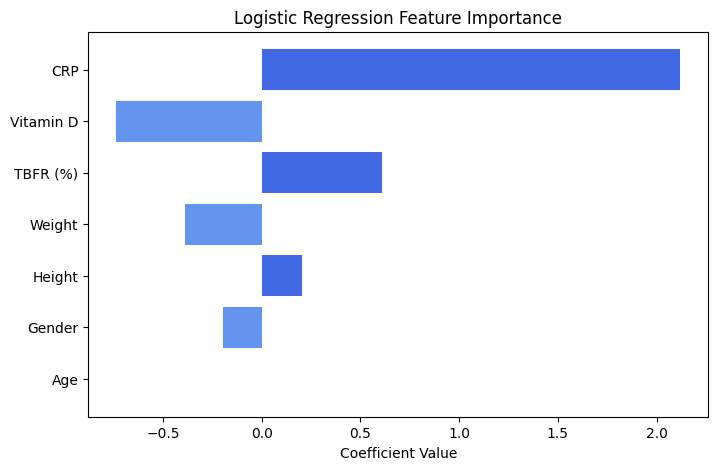


=== Model Explanation ===
The logistic regression model predicts the probability of gallstone presence as:
p(y=1 | x) = 1 / (1 + exp(-(w^T x + b)))

Positive coefficients → higher probability of gallstones.
Negative coefficients → lower probability of gallstones.


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Load and prepare data

# 2. Standardize (important before interpreting coefficients)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = X.columns

# 3. Train logistic regression with best lambda (from previous CV)
best_lambda = np.mean(lambda_list) if 'lambda_list' in locals() else 1.0  # example fallback
print(f"Using λ = {best_lambda}")

log_final = LogisticRegression(C=1/best_lambda, max_iter=1000)
log_final.fit(X_scaled, y)

# 4. Extract coefficients and sort by importance
coefs = log_final.coef_.flatten()
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Relevance": np.abs(coefs)
}).sort_values(by="Relevance", ascending=False)

print("\n=== Logistic Regression Coefficients ===")
print(coef_df.to_string(index=False))

# 5. Plot feature importance
plt.figure(figsize=(8,5))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color=np.sign(coef_df["Coefficient"]).map({1:"royalblue", -1:"cornflowerblue"}))
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# 6. Explain model prediction
print("\n=== Model Explanation ===")
print("The logistic regression model predicts the probability of gallstone presence as:")
print("p(y=1 | x) = 1 / (1 + exp(-(w^T x + b)))")
print("\nPositive coefficients → higher probability of gallstones.")
print("Negative coefficients → lower probability of gallstones.")
